In [1]:
import pandas as pd
import numpy as np
import re
import sklearn
from sklearn.utils import resample

#For Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
import itertools

#For model building
import sklearn 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB


def normalize_list(input_list):
    min_val = min(input_list)
    max_val = max(input_list)
    
    if min_val == max_val:
        # Handle the case where all values are the same to avoid division by zero
        return [0.0] * len(input_list)
    
    normalized_list = [(x - min_val) / (max_val - min_val) for x in input_list]
    
    return normalized_list

In [2]:
train_data = pd.read_csv('train.csv')

In [3]:
train_data = train_data.drop(['policy_id'], axis=1)

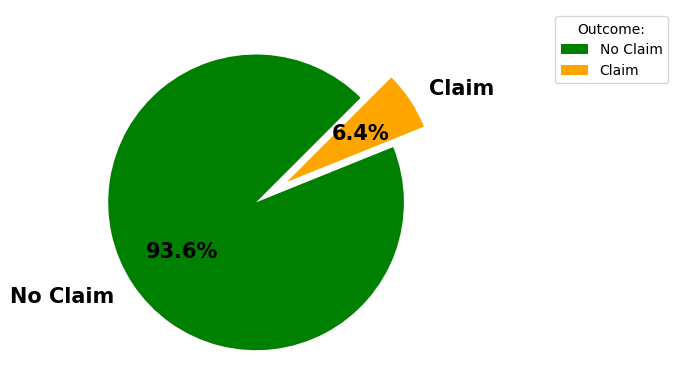

In [4]:
fig = plt.figure(facecolor='white')

ax = fig.add_subplot(1, 1, 1, facecolor='white')

plt.pie(train_data['is_claim'].value_counts(), labels=['No Claim', 'Claim'], radius=1, colors=['green', 'orange'],
        autopct='%1.1f%%', explode=[0.1, 0.15], labeldistance=1.15, startangle=45,
        textprops={'fontsize': 15, 'fontweight': 'bold'})

plt.legend(title='Outcome:', loc='upper right', bbox_to_anchor=(1.6, 1))

fig.patch.set_facecolor('white')

plt.show()

In [5]:
train_data['max_torque'].value_counts()
train_data['torque'] = train_data['max_torque'].apply(lambda x: re.findall(r'\d+\.?\d*(?=Nm)', x)[0])
train_data['rpm'] = train_data['max_torque'].apply(lambda x: re.findall(r'\d+\.?\d*(?=rpm)', x)[0])

# Convert the columns to numeric data type
train_data['torque'] = pd.to_numeric(train_data['torque'])
train_data['rpm'] = pd.to_numeric(train_data['rpm'])

# Calculate torque to RPM ratio 
train_data['torque to rpm ratio'] = train_data['torque'] / train_data['rpm']

In [6]:
# Deleting redundant columns from training set
train_data.drop('max_torque', axis=1,inplace=True)
train_data.drop('rpm',axis=1,inplace=True)
train_data.drop('torque',axis=1,inplace=True)

In [7]:
train_data['max_power'].value_counts()

max_power
88.50bhp@6000rpm     17796
40.36bhp@6000rpm     14948
113.45bhp@4000rpm    14018
55.92bhp@5300rpm      4173
67.06bhp@5500rpm      2373
97.89bhp@3600rpm      2114
88.77bhp@4000rpm      1598
61.68bhp@6000rpm      1209
118.36bhp@5500rpm      363
Name: count, dtype: int64

In [8]:
train_data['power'] = train_data['max_power'].apply(lambda x: re.findall(r'\d+\.?\d*(?=bhp)', x)[0])
train_data['rpm'] = train_data['max_power'].apply(lambda x: re.findall(r'\d+', x)[-1])

# Convert the columns to numeric data type
train_data['power'] = pd.to_numeric(train_data['power'])
train_data['rpm'] = pd.to_numeric(train_data['rpm'])

# Calculate power to RPM ratio
train_data['power to rpm ratio'] = train_data['power'] / train_data['rpm']

In [9]:
train_data.drop('power', axis=1,inplace=True)
train_data.drop('rpm',axis=1,inplace=True)
train_data.drop('max_power',axis=1,inplace=True)

In [10]:
is_cols=[col for col in train_data.columns if col.startswith("is") and col!="is_claim"]
print(is_cols)

['is_esc', 'is_adjustable_steering', 'is_tpms', 'is_parking_sensors', 'is_parking_camera', 'is_front_fog_lights', 'is_rear_window_wiper', 'is_rear_window_washer', 'is_rear_window_defogger', 'is_brake_assist', 'is_power_door_locks', 'is_central_locking', 'is_power_steering', 'is_driver_seat_height_adjustable', 'is_day_night_rear_view_mirror', 'is_ecw', 'is_speed_alert']


In [11]:
train_data = train_data.replace({ "No" : 0 , "Yes" : 1 })

In [12]:
dataset_num_col = train_data.select_dtypes(include=['int', 'float']).columns
print(" Data Set Numerical columns:")
print(dataset_num_col.nunique())
print(dataset_num_col)

 Data Set Numerical columns:
35
Index(['policy_tenure', 'age_of_car', 'age_of_policyholder',
       'population_density', 'make', 'airbags', 'is_esc',
       'is_adjustable_steering', 'is_tpms', 'is_parking_sensors',
       'is_parking_camera', 'displacement', 'cylinder', 'gear_box',
       'turning_radius', 'length', 'width', 'height', 'gross_weight',
       'is_front_fog_lights', 'is_rear_window_wiper', 'is_rear_window_washer',
       'is_rear_window_defogger', 'is_brake_assist', 'is_power_door_locks',
       'is_central_locking', 'is_power_steering',
       'is_driver_seat_height_adjustable', 'is_day_night_rear_view_mirror',
       'is_ecw', 'is_speed_alert', 'ncap_rating', 'is_claim',
       'torque to rpm ratio', 'power to rpm ratio'],
      dtype='object')


In [13]:
dataset_cat_cols = train_data.select_dtypes(include=['object']).columns
print("Data Set categorical columns:")
print(dataset_cat_cols.nunique())
print(dataset_cat_cols)

Data Set categorical columns:
8
Index(['area_cluster', 'segment', 'model', 'fuel_type', 'engine_type',
       'rear_brakes_type', 'transmission_type', 'steering_type'],
      dtype='object')


In [14]:
train_data= pd.get_dummies(train_data, columns=dataset_cat_cols,drop_first=True)


In [15]:
from imblearn.over_sampling import RandomOverSampler, SMOTE

def imbalanced_data(X_data, y_data):
    
    minority_class, majority_class = y_data.value_counts().sort_values().values
    print('\033[1m' + "Before Over Sampling" + '\033[0m')
    print(f"\nShape of the data : {X_data.shape}\n\nValue Counts\n{y_data.value_counts()}")
    
    if (minority_class * 2) > majority_class:
        print("Data is Balanced")
    else:
        print(f"\nData is Imbalanced")
        print('\n\033[1m' + "After Over Sampling" + '\033[0m\n')
        X_data, y_data = SMOTE().fit_resample(X_data, y_data)
        print(f"Shape of the data : {X_data.shape}\n\nValue Counts\n{y_data.value_counts()}")
        
    return X_data, y_data
y = train_data['is_claim']
train_data, y = imbalanced_data(train_data, y)

Before Over Sampling

Shape of the data : (58592, 87)

Value Counts
is_claim
0    54844
1     3748
Name: count, dtype: int64

Data is Imbalanced

After Over Sampling

Shape of the data : (109688, 87)

Value Counts
is_claim
0    54844
1    54844
Name: count, dtype: int64


In [16]:
X = train_data.drop(['is_claim'], axis=1)  # Features

from sklearn.preprocessing import StandardScaler
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
X_val,X_test,y_val,y_test=train_test_split(X_test,y_test,test_size=0.5,random_state=42,stratify=y_test)
boolean_columns = X_train.select_dtypes(include=['bool']).columns
for i in boolean_columns:
    X_train[i] = X_train[i].astype(int)
    X_val[i] = X_val[i].astype(int)
    X_test[i] = X_test[i].astype(int)

X_train_df = X_train.copy()
X_val_df = X_val.copy()
X_test_df = X_test.copy()

from sklearn.preprocessing import StandardScaler, Normalizer
X_train = StandardScaler().fit_transform(X_train)
X_val = StandardScaler().fit_transform(X_val)
X_test = StandardScaler().fit_transform(X_test)

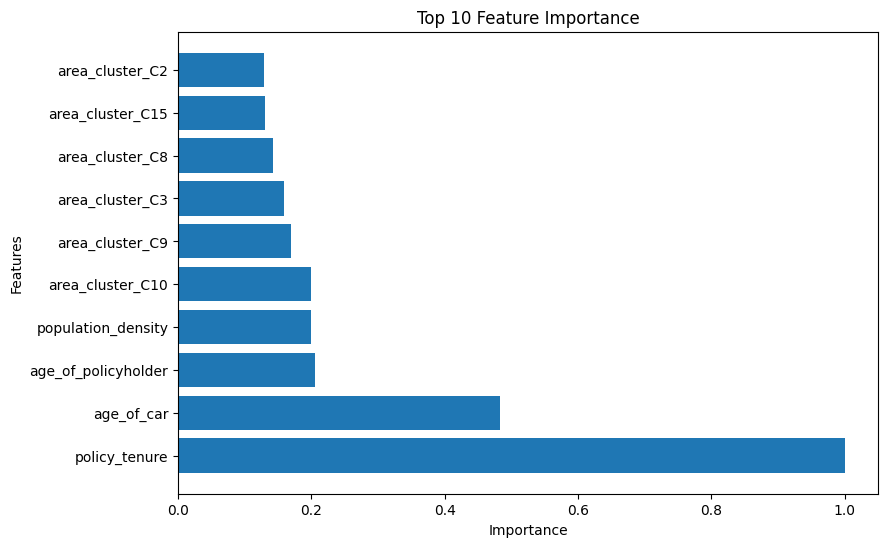

['policy_tenure', 'age_of_car', 'age_of_policyholder', 'population_density', 'area_cluster_C10', 'area_cluster_C9', 'area_cluster_C3', 'area_cluster_C8', 'area_cluster_C15', 'area_cluster_C2']


In [17]:
import model

classifier = model.LinearClassifier()
classifier.fit(X_train, y_train, X_val, y_val, re=False)
importance = classifier.get_feature_importance()

feature_names = list(X_train_df.columns)
len(feature_names),len(importance)
sorted_indices = np.argsort(importance)[::-1]
sorted_importance = importance[sorted_indices]
sorted_feature_names = [feature_names[i] for i in sorted_indices]

sorted_importance = normalize_list(sorted_importance)

top_n = len([value for i, value in enumerate(sorted_importance) if value > 0.12])
top_n = 10

plt.figure(figsize=(10, 6))
plt.barh(range(top_n), sorted_importance[:top_n], tick_label=sorted_feature_names[:top_n])
plt.title('Top 10 Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.subplots_adjust(left=0.2) 
plt.savefig("Linear Feature Importance.jpg")
plt.show()

print(sorted_feature_names[:top_n])
classifier_feature = sorted_feature_names[:top_n]

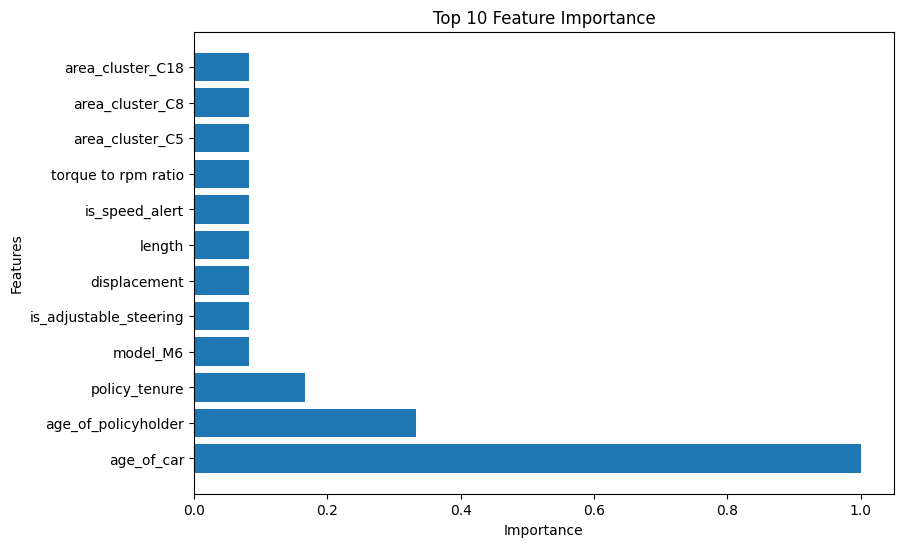

['age_of_car', 'age_of_policyholder', 'policy_tenure', 'model_M6', 'is_adjustable_steering', 'displacement', 'length', 'is_speed_alert', 'torque to rpm ratio', 'area_cluster_C5', 'area_cluster_C8', 'area_cluster_C18']


In [18]:
import model

Ptree = model.PruneDecisionTreeClassifier(max_depth=5, min_samples_split=2)  # 設置樹的最大深度
Ptree.fit(X_train, y_train)
importance = Ptree.feature_importance(X_train, y_train)  # Pass your feature matrix 'X_train' and target vector 'y_train'
feature_names = list(X_train_df.columns)
len(feature_names),len(importance)
sorted_indices = np.argsort(importance)[::-1]
sorted_importance = importance[sorted_indices]
sorted_feature_names = [feature_names[i] for i in sorted_indices]

sorted_importance = normalize_list(sorted_importance)

top_n = len([value for i, value in enumerate(sorted_importance) if value > 0.01])

plt.figure(figsize=(10, 6))
plt.barh(range(top_n), sorted_importance[:top_n], tick_label=sorted_feature_names[:top_n])
plt.title('Top 10 Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.subplots_adjust(left=0.2) 
plt.savefig("Decision Tree Feature Importance.jpg")
plt.show()

print(sorted_feature_names[:top_n])
tree_feature = sorted_feature_names[:top_n]

In [19]:
#特徵篩選
merged_feature_list = list(set(classifier_feature + tree_feature))
X = X[merged_feature_list]
print(X.shape)
#分割train:val:test = 8:1:1
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

boolean_columns = X_train.select_dtypes(include=['bool']).columns

for i in boolean_columns:
    X_train[i] = X_train[i].astype(int)
    X_test[i] = X_test[i].astype(int)

X_train_df = X_train.copy()
X_test_df = X_test.copy()

from sklearn.preprocessing import StandardScaler, Normalizer
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

(109688, 18)


In [20]:
#特徵篩選
merged_feature_list = list(set(classifier_feature + tree_feature))
X = X[merged_feature_list]
print(X.shape)
#分割train:val:test = 8:1:1
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
X_val,X_test,y_val,y_test=train_test_split(X_test,y_test,test_size=0.5,random_state=42,stratify=y_test)

boolean_columns = X_train.select_dtypes(include=['bool']).columns

for i in boolean_columns:
    X_train[i] = X_train[i].astype(int)
    X_val[i] = X_val[i].astype(int)
    X_test[i] = X_test[i].astype(int)

X_train_df = X_train.copy()
X_val_df = X_val.copy()
X_test_df = X_test.copy()

from sklearn.preprocessing import StandardScaler, Normalizer
X_train = StandardScaler().fit_transform(X_train)
X_val = StandardScaler().fit_transform(X_val)
X_test = StandardScaler().fit_transform(X_test)

(109688, 18)


###########################第三題開始###########################

In [21]:
#K-fold線性分類
import model
k_fold_list = [3,5,10]

for k_fold in k_fold_list:
    print(f'開始執行4個模型 {k_fold} folds跟Voting')
    model1 = model.LinearClassifier()
    Linear_list = model1.k_fold_cross_validation(X_train, y_train, k=k_fold)

    model2 = model.kNN()
    knn_list  = model2.kfold_cross_validation(X_train, y_train.to_numpy(), k=k_fold)

    model3 = model.DecisionTreeClassifier() 
    tree_list = model3.k_fold_cross_validation(X_train, y_train, k=k_fold)

    model4 = model.PruneDecisionTreeClassifier(max_depth=5, min_samples_split=2)  # 設置樹的最大深度
    Ptree_list = model4.k_fold_cross_validation(X_train, y_train, k=k_fold)

    Vote = model.VotingClassifier(Linear_list, knn_list, tree_list, Ptree_list)
    pre = Vote.predict(X_test, y_test)

開始執行4個模型 3 folds跟Voting
LinearClassifier訓練精確度: 57.29% | 驗證精確度: 57.90%
LinearClassifier訓練精確度: 57.77% | 驗證精確度: 57.12%
LinearClassifier訓練精確度: 57.61% | 驗證精確度: 57.57%
LinearClassifier K-Fold 交叉驗證完成。
LinearClassifier平均訓練精確度: 57.56%
LinearClassifier平均驗證精確度: 57.53%
kNN of Accuracy for Fold 1: 0.7778119658119658
kNN of Accuracy for Fold 2: 0.7755897435897436
kNN of Accuracy for Fold 3: 0.7778119658119658
kNN of Mean Accuracy across 3 folds: 0.7770712250712251
DecisionTree of Fold 1: Accuracy = 0.887931623931624
DecisionTree of Fold 2: Accuracy = 0.8873504273504274
DecisionTree of Fold 3: Accuracy = 0.8838974358974359
DecisionTree of Average Accuracy: 0.8863931623931623
第 1 折的 PruneDecisionTree 準確度：0.6424273504273504
第 2 折的 PruneDecisionTree 準確度：0.638051282051282
第 3 折的 PruneDecisionTree 準確度：0.6395555555555555
平均 PruneDecisionTree 準確度：0.640011396011396
VotingClassifier of Fold 10969 Average Accuracy: 0.6802807913209955
VotingClassifier of Fold 10969 Average Accuracy: 0.6706171939101103
VotingCla

###########################第三題結束###########################

In [22]:
# #K-fold線性分類
# import model
# model = model.LinearClassifier()
# Linear_list = model.k_fold_cross_validation(X_train, y_train, k=5)

In [23]:
# import model
# model = model.kNN()
# knn_list  = model.kfold_cross_validation(X_train, y_train.to_numpy(), k=5)

In [24]:
# import model

# model = model.DecisionTreeClassifier() 
# tree_list = model.k_fold_cross_validation(X_train, y_train, k=5)

In [25]:
# import model
# model = model.PruneDecisionTreeClassifier(max_depth=5, min_samples_split=2)  # 設置樹的最大深度
# Ptree_list = model.k_fold_cross_validation(X_train, y_train, k=5)

In [26]:
# import model
# Vote = model.VotingClassifier(Linear_list, knn_list, tree_list, Ptree_list)
# pre = Vote.predict(X_test, y_test)